# 1. Lobster thermal habitat
### This code calculates the area of lobster thermal habitat at seafloor using GLORYS reanalysis data
### The lobster thermal habitat is defined as the area at the seafloor with temperature less than or equal to 20C
# 2. Cold Pool Volume and Duration
### This code calculates the volume and duration of the cold pool within the NYB using GLORYS reanalysis data
### The cold pool is defined as the volume of water bounded by the 10C isotherm and the 34 psu contour

   
#### *This code was created by L. Gruenburg and last edited on Dec 6 2021

In [5]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import gsw
from holteandtalley import HolteAndTalley
import os
from xmovie import Movie
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import math

In [2]:
# Open the glorys data.  It was too large to download all at once so is split into 2 datasets which will be merged together
glorys1 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/global-reanalysis-phy-001-030-monthly_1630441480776.nc')

In [3]:
glorys2 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/global-reanalysis-phy-001-030-monthly_1630526463376.nc')

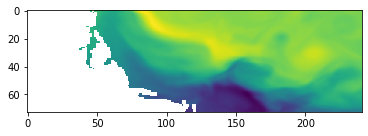

In [6]:
# Make a simple temperature plot just to see what it looks like
plt.imshow(glorys2.thetao[20,0,:,:])

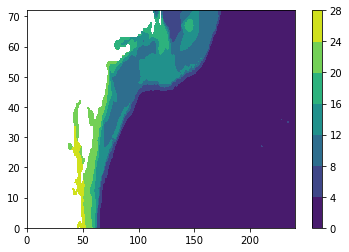

In [7]:
# Make another simple plot oriented with north up for easier understanding
c = plt.contourf(glorys2.bottomT[20,:,:])
#c = plt.contour(glorys2.bottomT[20,:,:],levels = 10,colors = 'k')
plt.colorbar(c)

In [8]:
# Merge the 2 datasets into one
glorys = xr.merge([glorys1,glorys2])

In [9]:
# See what the dataset looks like
glorys

<xarray.Dataset>
Dimensions:    (depth: 41, latitude: 73, longitude: 241, time: 324)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2019-12-16T12:00:00
  * depth      (depth) float32 0.494 1.541 2.646 ... 1.942e+03 2.225e+03
  * latitude   (latitude) float32 36.0 36.08 36.17 36.25 ... 41.83 41.92 42.0
  * longitude  (longitude) float32 -80.0 -79.92 -79.83 ... -60.17 -60.08 -60.0
Data variables:
    mlotst     (time, latitude, longitude) float32 nan nan nan ... 83.93 84.99
    vo         (time, depth, latitude, longitude) float32 nan nan ... 0.0293
    thetao     (time, depth, latitude, longitude) float32 nan nan ... 3.108
    uo         (time, depth, latitude, longitude) float32 nan nan ... 0.01404
    bottomT    (time, latitude, longitude) float32 nan nan nan ... 1.86 1.858
    so         (time, depth, latitude, longitude) float32 nan nan ... 34.95
    zos        (time, latitude, longitude) float32 nan nan ... -0.5179 -0.5072

In [10]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')

In [11]:
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)

In [12]:
# Extract the polygon
nyb_shape = NYB.geometry[0]

In [14]:
# Function that checks if the points are within the NYB (variable with depth - FOR COLD POOL)
def inNYB(longitude, latitude, time, depth, var, shape):
    X = longitude
    Y = latitude
    x, y = np.meshgrid(X, Y)
    empty = np.empty([len(time), len(depth), len(latitude), len(longitude)])
    empty[:,:,:,:] = np.nan
    for i in range(len(latitude)):
        for j in range(len(longitude)):
            if Point(x[i,j], y[i,j]).within(shape) == True:
                empty[:,:,i,j] = var[:,:,i,j]
    return empty

In [15]:
#subset of glorys pot temp for just the NYB (FOR COLD POOL)
glorys_nyb_theta = inNYB(glorys.longitude,glorys.latitude,glorys.time,glorys.depth, glorys.thetao, nyb_shape)

In [16]:
#subset of glorys salinity for just the NYB (FOR COLD POOL)
glorys_nyb_salt = inNYB(glorys.longitude,glorys.latitude,glorys.time,glorys.depth, glorys.so, nyb_shape)

In [17]:
# Function that checks if the points are within the NYB (variable without depth - FOR LOBSTER THERMAL HABITAT)
def inNYB_nodepth(longitude, latitude, time, var, shape):
    X = longitude
    Y = latitude
    x, y = np.meshgrid(X, Y)
    empty = np.empty([len(time), len(latitude), len(longitude)])
    empty[:,:,:] = np.nan
    for i in range(len(latitude)):
        for j in range(len(longitude)):
            if Point(x[i,j], y[i,j]).within(shape) == True:
                empty[:,i,j] = var[:,i,j]
    return empty

In [18]:
#subset of glorys bottom temp for just the NYB (FOR LOBSTER THERMAL HABITAT)
glorys_nyb_bot_t = inNYB_nodepth(glorys.longitude,glorys.latitude,glorys.time, glorys.bottomT, nyb_shape)

In [19]:
# Reanalysis data is at a quarter of a degree, but the absolute distance changes with latitude.  This calculates those distances.
lon_at_lat = np.empty(73)
lon_at_lat[:] = np.nan
for i in range(73):
    lon_at_lat[i] = (1/12) * math.cos(np.radians(glorys.latitude[i])) * 111.3

In [20]:
# Difference between degrees of latitude roughly the same
lat_diff = 110*(1/12)
lat_diff

9.166666666666666

In [21]:
# 1/12 degree is approximately 7km
(1/12) * math.cos(np.radians(glorys.latitude[i])) * 111.3

6.892668129705014

In [22]:
# See what the areas of the boxes will be like
lon_at_lat*lat_diff

array([68.78329817, 68.71054262, 68.63763874, 68.56459266, 68.49140153,
       68.41806252, 68.34458179, 68.27095346, 68.19718071, 68.12326672,
       68.04920862, 67.97500354, 67.90065771, 67.82616824, 67.75152918,
       67.67675292, 67.60183349, 67.52676799, 67.45156272, 67.37621477,
       67.3007212 , 67.22508525, 67.14931021, 67.07339   , 66.99733102,
       66.92113032, 66.84478493, 66.76830127, 66.69167637, 66.6149041 ,
       66.53799721, 66.46094956, 66.38375816, 66.30642951, 66.22896059,
       66.15134839, 66.07359625, 65.99570753, 65.917676  , 65.83950824,
       65.7612012 , 65.68275184, 65.60416675, 65.52543966, 65.44657395,
       65.36757302, 65.28843383, 65.20915328, 65.12973803, 65.05018502,
       64.97048787, 64.89065981, 64.81069448, 64.73058878, 64.65034943,
       64.56997332, 64.48945732, 64.40880821, 64.32801954, 64.24709478,
       64.16603743, 64.08484435, 64.00351238, 63.92204835, 63.8404491 ,
       63.75870811, 63.67683894, 63.59483507, 63.51269331, 63.43

In [23]:
# Want a 2D array for area
lons, area = np.meshgrid(glorys.longitude, lon_at_lat*lat_diff)

<ipython-input-24-22992781933b>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolor(glorys.longitude, glorys.latitude, area)


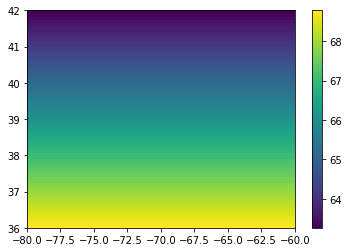

In [24]:
# Visualize the areas in lat lon space.  Notice larger area at the south smaller to the north - as expected!
c = plt.pcolor(glorys.longitude, glorys.latitude, area)
plt.colorbar(c)

## Lobster Thermal Habitat

In [25]:
# Doing a quick test on the first time step
subset = glorys_nyb_bot_t[0,:,:]

In [26]:
# Quick test on that first time step to see if the area less than or equal to 20C is working
subset[np.where(glorys_nyb_bot_t[0,:,:]<=20)]
Area = np.sum(area[np.where(glorys_nyb_bot_t[0,:,:]<=20)])
Area

42776.96407357517

In [27]:
# Loop through each month and calculate the area at each time step
Area = np.empty(324)
Area[:] = np.nan
for i in range(324):
    Area[i] = np.sum(area[np.where(glorys_nyb_bot_t[i,:,:]<=20)])

In [28]:
bott_subset_seas = glorys.bottomT.groupby('time.season').mean('time')

In [29]:
bott_subset_seas

<xarray.DataArray 'bottomT' (season: 4, latitude: 73, longitude: 241)>
array([[[      nan,       nan,       nan, ..., 1.8332182, 1.8340232,
         1.8339418],
        [      nan,       nan,       nan, ..., 1.8343395, 1.835443 ,
         1.8345928],
        [      nan,       nan,       nan, ..., 1.8352712, 1.8363833,
         1.8360128],
        ...,
        [      nan,       nan,       nan, ..., 1.8491796, 1.8473439,
         1.8462946],
        [      nan,       nan,       nan, ..., 1.8519828, 1.8500837,
         1.8492699],
        [      nan,       nan,       nan, ..., 1.8552747, 1.854126 ,
         1.8535023]],

       [[      nan,       nan,       nan, ..., 1.834159 , 1.8347921,
         1.834846 ],
        [      nan,       nan,       nan, ..., 1.8353256, 1.8362933,
         1.8356061],
        [      nan,       nan,       nan, ..., 1.8361127, 1.8372703,
         1.8370893],
...
        [      nan,       nan,       nan, ..., 1.8494685, 1.8474069,
         1.8462495],
        [      nan,       nan,       nan, ..., 1.8519287, 1.849948 ,
         1.8489894],
        [      nan,       nan,       nan, ..., 1.854488 , 1.8529776,
         1.8521184]],

       [[      nan,       nan,       nan, ..., 1.8354973, 1.8358226,
         1.8355879],
        [      nan,       nan,       nan, ..., 1.8363924, 1.8372065,
         1.8363657],
        [      nan,       nan,       nan, ..., 1.836944 , 1.8380295,
         1.8377042],
        ...,
        [      nan,       nan,       nan, ..., 1.849252 , 1.8472537,
         1.8461777],
        [      nan,       nan,       nan, ..., 1.8516304, 1.8495778,
         1.8487461],
        [      nan,       nan,       nan, ..., 1.8539548, 1.8529599,
         1.852508 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 36.0 36.08 36.17 36.25 ... 41.83 41.92 42.0
  * longitude  (longitude) float32 -80.0 -79.92 -79.83 ... -60.17 -60.08 -60.0
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'

/Users/nyelab/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/nyelab/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/nyelab/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


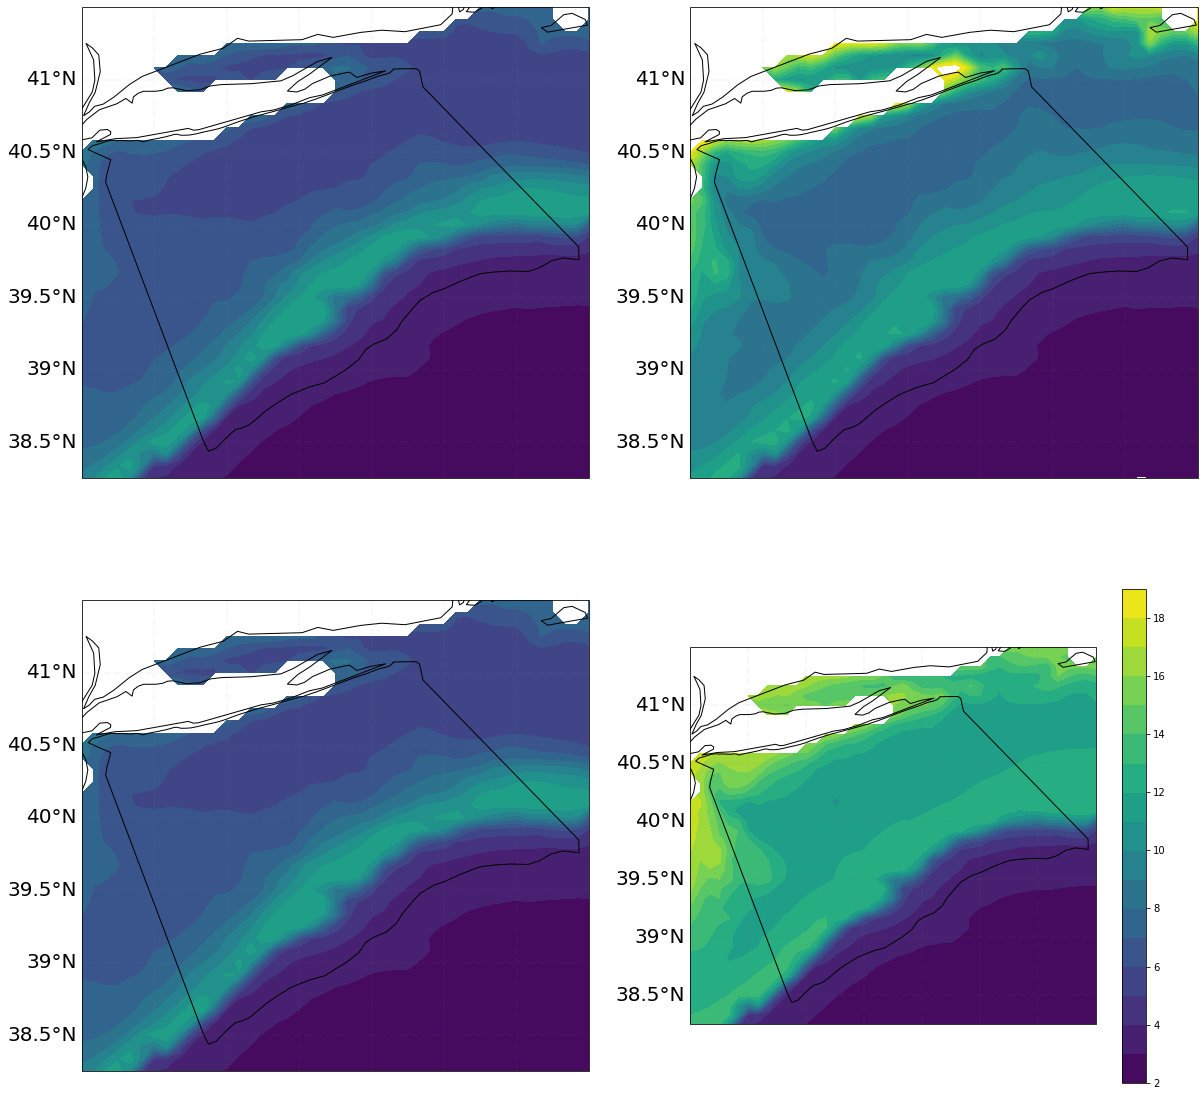

In [30]:
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [286,289.5,38.25,41.5]
gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.05, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
ax[0,0].set_extent(extent)
ax[0,0].coastlines(resolution='50m')
CS = ax[0,0].contourf(glorys.longitude,glorys.latitude,bott_subset_seas[2,:,:],levels = np.arange(2,20,1),transform=ccrs.PlateCarree())
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[0,0].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
    
gl = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.05, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
ax[0,1].set_extent(extent)
ax[0,1].coastlines(resolution='50m')
CS = ax[0,1].contourf(glorys.longitude,glorys.latitude,bott_subset_seas[1,:,:],levels = np.arange(2,20,1),transform=ccrs.PlateCarree())
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[0,1].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
    
gl = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.05, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
ax[1,0].set_extent(extent)
ax[1,0].coastlines(resolution='50m')
CS = ax[1,0].contourf(glorys.longitude,glorys.latitude,bott_subset_seas[2,:,:],levels = np.arange(2,20,1),transform=ccrs.PlateCarree())
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[1,0].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)

gl = ax[1,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.05, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
ax[1,1].set_extent(extent)
ax[1,1].coastlines(resolution='50m')
CS = ax[1,1].contourf(glorys.longitude,glorys.latitude,bott_subset_seas[3,:,:],levels = np.arange(2,20,1),transform=ccrs.PlateCarree())
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[1,1].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)

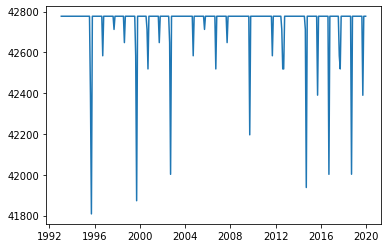

In [31]:
plt.plot(glorys.time, Area)

In [32]:
#Total area of NYB at seafloor
Area[0]

42776.96407357517

In [33]:
#Check when Lobster Thermal habitat is more than 1% inhospitable
np.where(((Area[0]-Area)/Area[0])*100>1)

(array([ 32,  80, 116, 200, 260, 284, 308]),)

In [339]:
LTH[LTH.Percent_Inhospitable >2
   ]

,Percent_Inhospitable
1995-09-16,2.265686
1999-09-16,2.114553


Text(0.5, 1.0, 'Lobster Thermal Habitat')

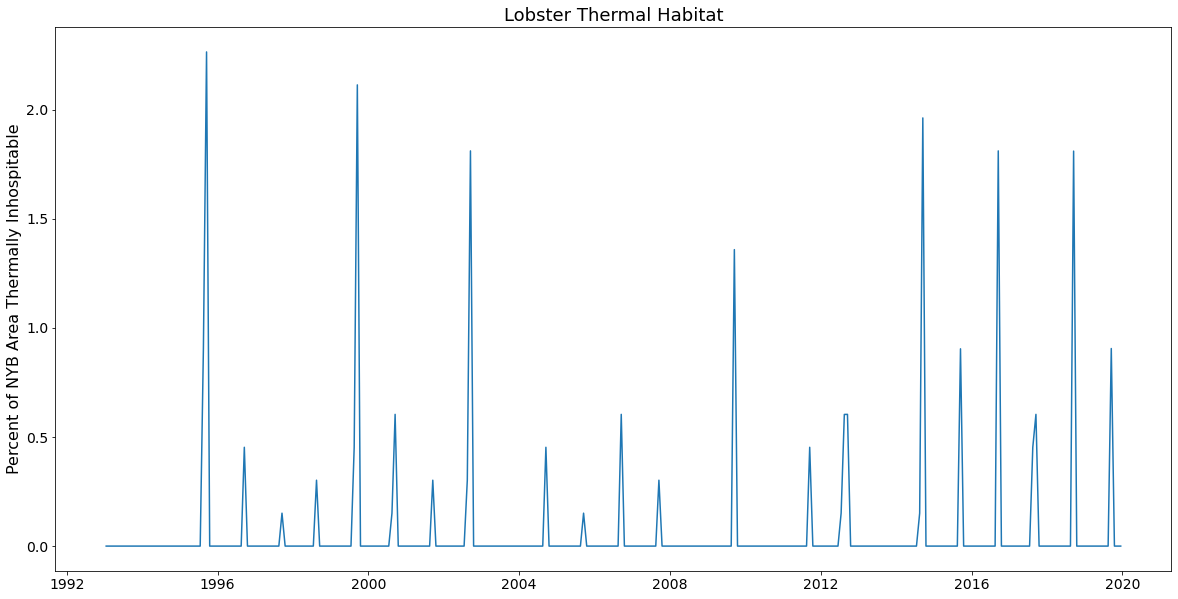

In [34]:
#Time series of %Area inhospitable to lobsters
fig, ax = plt.subplots(figsize = [20,10])
plt.plot(glorys.time, ((Area[0]-Area)/Area[0])*100)
ax.tick_params(labelsize = 14)
ax.set_ylabel('Percent of NYB Area Thermally Inhospitable', fontsize = 16)
ax.set_title('Lobster Thermal Habitat', fontsize = 18)

In [253]:
# Create one pandas data frame and save to final timeseries folder
d = {'Percent_Inhospitable': ((Area[0]-Area)/Area[0])*100}
LTH = pn.DataFrame(data = d, index = glorys.time.values)
LTH.to_csv('/Users/nyelab/Desktop/NYB Indicators/FInal_Timeseries/Lobster_Thermal_Hab_Dec_6_2021.csv')

In [318]:
LTH_yearly = LTH.groupby(LTH.index.year).mean()

In [320]:
LTH_yearly.to_csv('/Users/nyelab/Desktop/NYB Indicators/FInal_Timeseries/Lobster_Thermal_Hab_Jan_6_2022.csv')

Text(0.5, 1.0, 'September 2018')

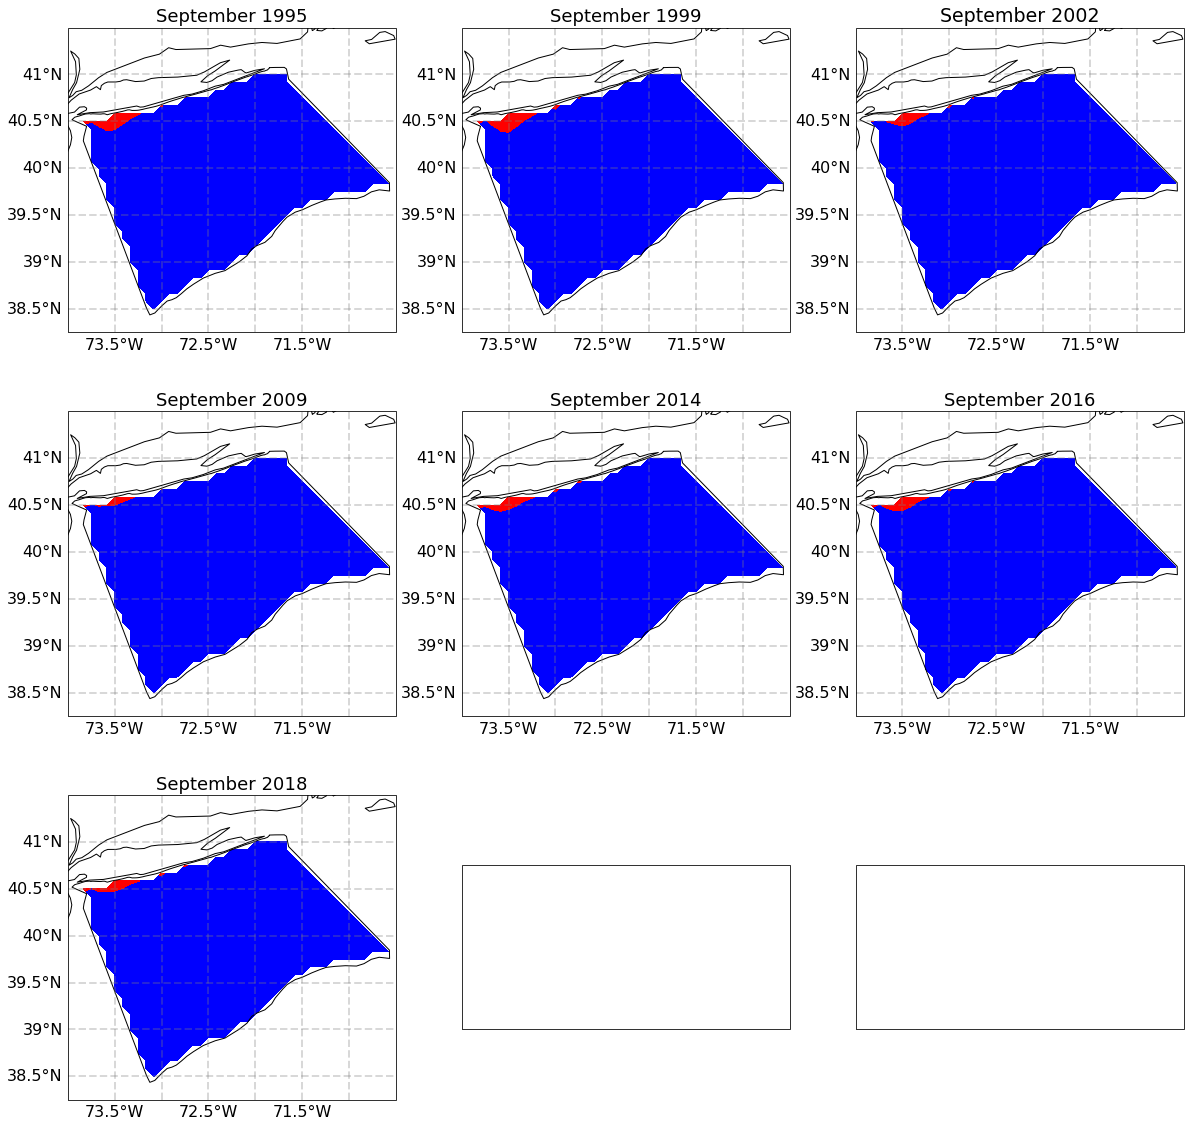

In [336]:
#Plot the months where inhospitable lobster thermal habitat is > 1%
fig,ax = plt.subplots(ncols = 3, nrows = 3, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [286,289.5,38.25,41.5]
gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = True
gl.ylabel_style = {'size': 16, 'color': 'k'}
gl.xlabel_style = {'size': 16, 'color': 'k'}
ax[0,0].set_extent(extent)
ax[0,0].coastlines(resolution='50m')
CS = ax[0,0].contourf(glorys.longitude,glorys.latitude,glorys_nyb_bot_t[32,:,:],levels = [20,20.0001],extend = 'both',transform=ccrs.PlateCarree(),cmap = 'bwr')
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[0,0].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
ax[0,0].set_title(pn.to_datetime(glorys.time[32].values).strftime("%B %Y"), fontsize = 18)
    
gl = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = True
gl.ylabel_style = {'size': 16, 'color': 'k'}
gl.xlabel_style = {'size': 16, 'color': 'k'}
ax[0,1].set_extent(extent)
ax[0,1].coastlines(resolution='50m')
CS = ax[0,1].contourf(glorys.longitude,glorys.latitude,glorys_nyb_bot_t[80,:,:],levels = [20,20.0001],extend = 'both',transform=ccrs.PlateCarree(),cmap = 'bwr')
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[0,1].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
ax[0,1].set_title(pn.to_datetime(glorys.time[80].values).strftime("%B %Y"), fontsize = 18)
    
gl = ax[0,2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = True
gl.ylabel_style = {'size': 16, 'color': 'k'}
gl.xlabel_style = {'size': 16, 'color': 'k'}
ax[0,2].set_extent(extent)
ax[0,2].coastlines(resolution='50m')
CS = ax[0,2].contourf(glorys.longitude,glorys.latitude,glorys_nyb_bot_t[116,:,:],levels = [20,20.0001],extend = 'both',transform=ccrs.PlateCarree(),cmap = 'bwr')
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[0,2].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
ax[0,2].set_title(pn.to_datetime(glorys.time[116].values).strftime("%B %Y"), fontsize = 19)

gl = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = True
gl.ylabel_style = {'size': 16, 'color': 'k'}
gl.xlabel_style = {'size': 16, 'color': 'k'}
ax[1,0].set_extent(extent)
ax[1,0].coastlines(resolution='50m')
CS = ax[1,0].contourf(glorys.longitude,glorys.latitude,glorys_nyb_bot_t[200,:,:],levels = [20,20.0001],extend = 'both',transform=ccrs.PlateCarree(),cmap = 'bwr')
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[1,0].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
ax[1,0].set_title(pn.to_datetime(glorys.time[200].values).strftime("%B %Y"), fontsize = 18)
    
gl = ax[1,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = True
gl.ylabel_style = {'size': 16, 'color': 'k'}
gl.xlabel_style = {'size': 16, 'color': 'k'}
ax[1,1].set_extent(extent)
ax[1,1].coastlines(resolution='50m')
CS = ax[1,1].contourf(glorys.longitude,glorys.latitude,glorys_nyb_bot_t[260,:,:],levels = [20,20.0001],extend = 'both',transform=ccrs.PlateCarree(),cmap = 'bwr')
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[1,1].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
ax[1,1].set_title(pn.to_datetime(glorys.time[260].values).strftime("%B %Y"), fontsize = 18)

gl = ax[1,2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = True
gl.ylabel_style = {'size': 16, 'color': 'k'}
gl.xlabel_style = {'size': 16, 'color': 'k'}
ax[1,2].set_extent(extent)
ax[1,2].coastlines(resolution='50m')
CS = ax[1,2].contourf(glorys.longitude,glorys.latitude,glorys_nyb_bot_t[284,:,:],levels = [20,20.0001],extend = 'both',transform=ccrs.PlateCarree(),cmap = 'bwr')
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[1,2].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
ax[1,2].set_title(pn.to_datetime(glorys.time[284].values).strftime("%B %Y"), fontsize = 18)
    
gl = ax[2,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = True
gl.ylabel_style = {'size': 16, 'color': 'k'}
gl.xlabel_style = {'size': 16, 'color': 'k'}
ax[2,0].set_extent(extent)
ax[2,0].coastlines(resolution='50m')
CS = ax[2,0].contourf(glorys.longitude,glorys.latitude,glorys_nyb_bot_t[308,:,:],levels = [20,20.0001],extend = 'both',transform=ccrs.PlateCarree(),cmap = 'bwr')
#ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
#ax[0,0].clabel(CS, fontsize=16, inline=1, fmt=text2)
#ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
ax[2,0].add_geometries(NYB.geometry,
        ccrs.PlateCarree(),
        facecolor='none', edgecolor = 'k')#hatch='xxxx')
#plt.colorbar(CS)
            #ax[0,0].set_title('20C isotherm surface SON 1982-1989', fontsize = 20)
ax[2,0].set_title(pn.to_datetime(glorys.time[308].values).strftime("%B %Y"), fontsize = 18)

In [328]:
pn.to_datetime(glorys.time[308].values).strftime("%Y-%m")


'2018-09'

In [36]:
# Returns depth of the 10degree isotherm at each grid point and each month
def depth10(temp,ntime,ndepth,nlat,nlon):
    d10 = np.empty([ntime,nlat,nlon])
    d10[:,:,:] = np.nan
    for i in range(25,70):
        for j in range(70,115):
            point = temp[:,:,i,j]
            for k in range(324):
                if np.any(point[k,:]>0):
                    x = 10
                    xp = point[k,:]
                    xp = np.flip(xp[np.where(xp>0)])
                    y = glorys.depth
                    y = np.flip(y[np.where(xp>0)])
                    d10[k,i,j] = np.interp(x,xp,y)
        print(i)
    return d10

In [46]:
# returns a matrix of where the temperature of the water is less than 10 degrees at each grid point and each month and depth
def less_than_10(temp,ntime,ndepth,nlat,nlon):
    LT10 = np.empty([ntime,ndepth,nlat,nlon])
    LT10[:,:,:,:] = np.nan
    for i in range(25,70):
        for j in range(70,115):
            point = temp[:,:,i,j]
            for k in range(324):
                if np.any(point[k,:]>0):
                    index_T = np.where(point[k,:]<=10)
                    LT10[k,index_T,i,j] = 1
        print(i)
    return LT10

In [53]:
# returns a metrix of where the salinity of the water is less than 34 PSU at each gridpoint and each month and depth
def less_than_34(salt,ntime,ndepth,nlat,nlon):
    LT34 = np.empty([ntime,ndepth,nlat,nlon])
    LT34[:,:,:,:] = np.nan
    for i in range(25,70):
        for j in range(70,115):
            point = salt[:,:,i,j]
            for k in range(324):
                if np.any(point[k,:]>0):
                    index_T = np.where(point[k,:]<=34)
                    LT34[k,index_T,i,j] = 1
        print(i)
    return LT34

In [37]:
# Returns the depth of the 34 PSU salinity contour at each gridpoint and each month
def depth34(salinity,ntime,ndepth,nlat,nlon):
    d34 = np.empty([ntime,nlat,nlon])
    d34[:,:,:] = np.nan
    for i in range(25,70):
        for j in range(70,115):
            point = salinity[:,:,i,j]
            for k in range(324):
                p = point[k,:]
                no = np.where(np.isnan(p)==False)
                p = p[no]
                if np.any(p>0):
                    if p.max()<34:
                        d34[k,i,j] = 0.494025
                    if p.min()<34 and p.max()>34:
                        x = 34
                        xp = p
                        y = glorys.depth[no]
                        d34[k,i,j] = np.interp(x,xp,y)
        print(i)
    return d34

In [38]:
# Find depth of the 10 degree isotherm
d10 = depth10(glorys_nyb_theta,324,41,73,241)

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [39]:
# Find depth of the 34 PSU isohaline
d34 = depth34(glorys_nyb_salt,324,41,73,241)

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [52]:
# Find everywhere the temp is equal to or less than 10 degrees
LT10 = less_than_10(glorys_nyb_theta,324,41,73,241)

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [54]:
# Find everywhere the salinity is equal to or less than 34 PSU
LT34 = less_than_34(glorys_nyb_salt,324,41,73,241)

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [55]:
# puts a 1 in a matrix where both temp <= 10 and salinity <= 34.  Everywhere else is a zero.
LT_34_10 = LT34 * LT10

In [64]:
# Find the volume of this cold fresh water
volume = np.nansum(np.nansum(np.nansum(((area * 1000 * 1000) * 10 * LT_34_10),1),1),1)

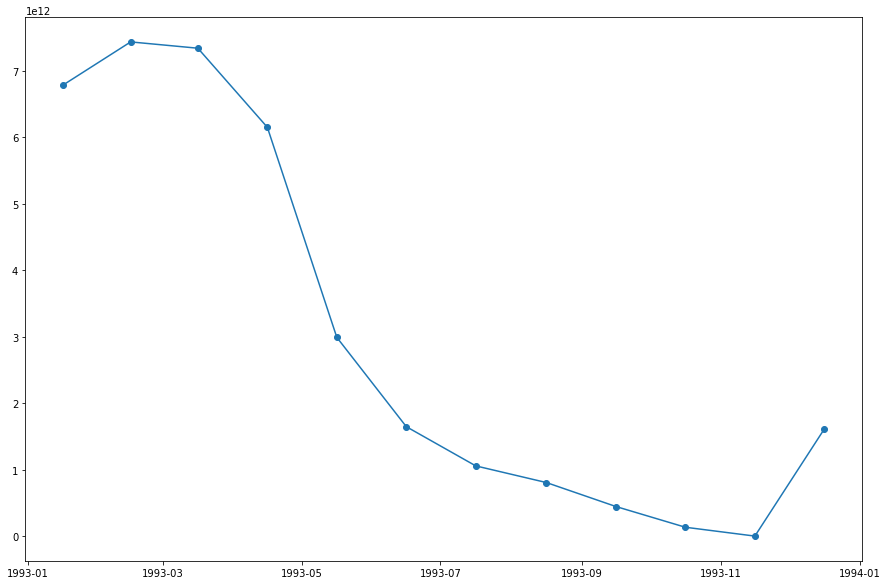

In [88]:
# Take a quick look at the first year
fig,ax = plt.subplots(figsize = (15,10))
plt.plot(glorys.time[0:12],volume[0:12])
plt.scatter(glorys.time[0:12],volume[0:12])

In [106]:
# Testing an onset/breakdown idea based on the change of the slope of the graph above
test = volume[:12]
slope_test = np.diff(test)
yn = np.empty(11)
yn[np.where(slope_test>0)] = 1
yn[np.where(slope_test<0)] = -1
k=0
while k<11:
    if yn[k] * yn[k+1] < 0:
        onset = glorys.time[k+1+1]
        onset_ind = k+1+1
        b = k+1+1
        k=12
    else:
        k=k+1
        
while b<11:
    if yn[b] * yn[b+1] < 0:
        breakdown = glorys.time[b+1+1]
        breakdown_ind = b+1+1
        b = 12
    else:
        b = b+1



In [116]:
# Index for the first month of each year
yr_start = np.arange(0,324,12)

In [118]:
# Number of years of data
len(yr_start)

27

In [199]:
# Another test of onset/breakdown
onset = np.empty(27)
onset[:] = 0
onset_ind = np.empty(27)
onset_ind[:] = 0
breakdown_ind = np.empty(27)
breakdown_ind[:] = 0
breakdown = np.empty(27)
breakdown[:] = 0
for i in range(27):
    year_vector = volume[yr_start[i]:yr_start[i]+12]
    time_vector = glorys.time[yr_start[i]:yr_start[i]+12]
    point_by_point_slope = np.diff(year_vector)
    yn = np.empty(11)
    yn[:] = 0
    yn[np.where(point_by_point_slope>0)] = 1
    yn[np.where(point_by_point_slope<0)] = -1
    k=0
    while k<11:
        if yn[k] + yn[k+1] !=2:
            onset[i] = time_vector[k+1+1].values
            onset_ind[i] = yr_start[i] + k+1+1
            b = k+1+1
            k=12
        else:
            k=k+1
        
    while b<11:
        if yn[b] + yn[b+1] == 0 or yn[b] + yn[b+1] == 1 or yn[b] + yn[b+1] == -1:
            breakdown[i] = time_vector[b+1+1].values
            breakdown_ind[i] = yr_start[i] + b+1+1
            b = 12
        else:
            b = b+1


Text(0, 0.5, 'Volume ($km^3$)')

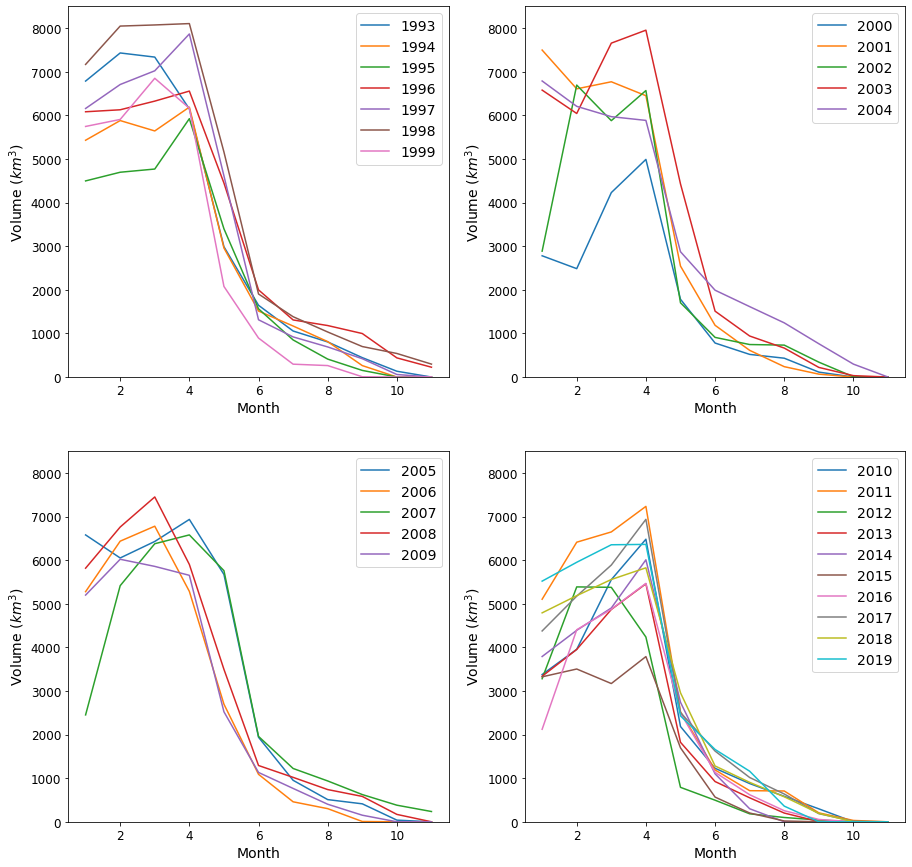

In [350]:
# Plotting all the volume data

years = np.arange(1993,2020)
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = [15,15])
for i in range(7):
    ax[0,0].plot(np.arange(1,12,1), volume[yr_start[i]:yr_start[i]+11]/(1000*1000*1000), label = years[i])
ax[0,0].legend(fontsize = 14)
ax[0,0].set_ylim([0,8500])
ax[0,0].tick_params(labelsize = 12)
ax[0,0].set_xlabel('Month', fontsize = 14)
ax[0,0].set_ylabel('Volume ($km^3$)', fontsize = 14)

for i in range(5):
    ax[0,1].plot(np.arange(1,12,1), volume[yr_start[7+i]:yr_start[7+i]+11]/(1000*1000*1000), label = years[7+i])
ax[0,1].legend(fontsize = 14)
ax[0,1].set_ylim([0,8500])
ax[0,1].tick_params(labelsize = 12)
ax[0,1].set_xlabel('Month', fontsize = 14)
ax[0,1].set_ylabel('Volume ($km^3$)', fontsize = 14)

for i in range(5):
    ax[1,0].plot(np.arange(1,12,1), volume[yr_start[12+i]:yr_start[12+i]+11]/(1000*1000*1000), label = years[12+i])
ax[1,0].legend(fontsize = 14)
ax[1,0].set_ylim([0,8500])
ax[1,0].tick_params(labelsize = 12)
ax[1,0].set_xlabel('Month', fontsize = 14)
ax[1,0].set_ylabel('Volume ($km^3$)', fontsize = 14)

for i in range(10):
    ax[1,1].plot(np.arange(1,12,1), volume[yr_start[17+i]:yr_start[17+i]+11]/(1000*1000*1000), label = years[17+i])
ax[1,1].legend(fontsize = 14)
ax[1,1].set_ylim([0,8500])
ax[1,1].tick_params(labelsize = 12)
ax[1,1].set_xlabel('Month', fontsize = 14)
ax[1,1].set_ylabel('Volume ($km^3$)', fontsize = 14)

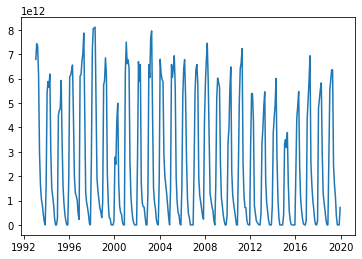

In [203]:
plt.plot(glorys.time,volume)

In [226]:
Aprils = np.arange(3,325,12)
Julys = np.arange(6,325,12)
Octobers = np.arange(9, 325, 12)
Years = np.arange(1993,2021,1)

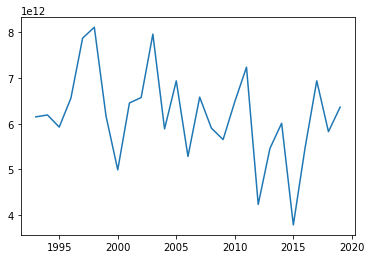

In [236]:
plt.plot(Years[:-1],volume[Aprils])


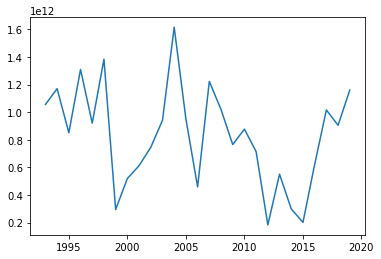

In [237]:
plt.plot(Years[:-1], volume[Julys])

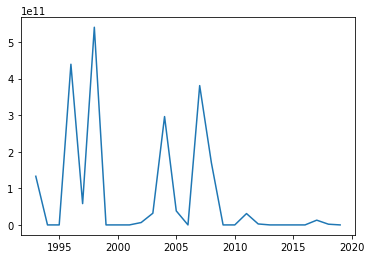

In [238]:
plt.plot(Years[:-1], volume[Octobers])

In [249]:
# Create one pandas data frame for Aprils, Julys, and Octobers and save to final timeseries folder
d = {'April': volume[Aprils], 'July': volume[Julys], 'October': volume[Octobers]}
CP_vol = pn.DataFrame(data = d, index = Years[:-1])
CP_vol.to_csv('/Users/nyelab/Desktop/NYB Indicators/FInal_Timeseries/CP_volume_Dec_6_2021.csv')

## Everything after this is old stuff and unnecessary for the Inidcator at this time

In [202]:
onset_month = [2,4,4,4,4,4,3,4,3,4]

<xarray.DataArray 'time' (time: 27)>
array(['1993-03-16T12:00:00.000000000', '1994-03-16T12:00:00.000000000',
       '1995-05-16T12:00:00.000000000', '1996-05-16T12:00:00.000000000',
       '1997-05-16T12:00:00.000000000', '1998-05-16T12:00:00.000000000',
       '1999-04-16T00:00:00.000000000', '2000-03-16T12:00:00.000000000',
       '2001-03-16T12:00:00.000000000', '2002-03-16T12:00:00.000000000',
       '2003-03-16T12:00:00.000000000', '2004-03-16T12:00:00.000000000',
       '2005-03-16T12:00:00.000000000', '2006-04-16T00:00:00.000000000',
       '2007-05-16T12:00:00.000000000', '2008-04-16T00:00:00.000000000',
       '2009-03-16T12:00:00.000000000', '2010-05-16T12:00:00.000000000',
       '2011-05-16T12:00:00.000000000', '2012-03-16T12:00:00.000000000',
       '2013-05-16T12:00:00.000000000', '2014-05-16T12:00:00.000000000',
       '2015-03-16T12:00:00.000000000', '2016-05-16T12:00:00.000000000',
       '2017-05-16T12:00:00.000000000', '2018-05-16T12:00:00.000000000',
       '2019-05-16T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-03-16T12:00:00 ... 2019-05-16T12:00:00
Attributes:
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    _CoordinateAxisType:  Time
    valid_min:            377316.0
    valid_max:            481764.0

In [83]:
np.where(np.diff(volume[:12])<0)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),)

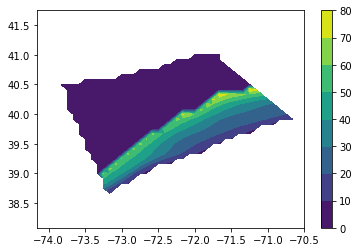

In [40]:
c = plt.contourf(glorys.longitude[70:115],glorys.latitude[25:70],d34[16,25:70,70:115])#,levels = np.arange(0,15,1))
plt.colorbar(c)

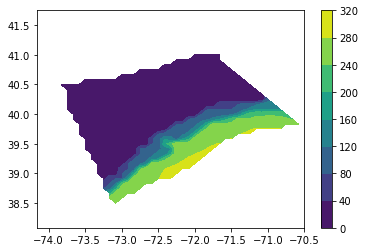

In [41]:
c = plt.contourf(glorys.longitude[70:115],glorys.latitude[25:70],d10[16,25:70,70:115])#,levels = np.arange(0,15,1))
plt.colorbar(c)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/nyelab/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/nyelab/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


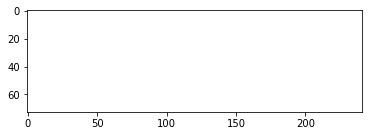

In [92]:
plt.imshow(d34[0,:,:])

In [91]:
test = glorys_nyb_theta[:,:,50,100]

In [30]:
x = 10
xp = glorys_nyb_theta[0,:,50,100]
y = glorys.depth
yp = np.interp(x,xp,y)
xp

array([8.19467735, 8.1961422 , 8.1961422 , 8.19687462, 8.19760704,
       8.19760704, 8.19833946, 8.19833946, 8.19833946, 8.19907188,
       8.19907188, 8.19980431, 8.19980431, 8.20126915, 8.20419979,
       8.21738338, 8.24887848, 8.33603954, 8.49790955, 8.84582043,
       9.99136353,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

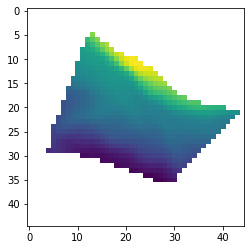

In [360]:
plt.imshow(glorys_nyb_theta[0,10,25:70,70:115])

In [42]:
topo = xr.open_dataset("/Users/nyelab/Downloads/ETOPO1_Bed_g_gmt4(1).grd")

In [43]:
topo

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Bed_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

In [106]:
(glorys.longitude)

<xarray.DataArray 'longitude' (longitude: 241)>
array([-80.      , -79.916664, -79.833336, ..., -60.166668, -60.083332,
       -60.      ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.92 -79.83 ... -60.17 -60.08 -60.0
Attributes:
    valid_min:            -80.0
    valid_max:            -60.0
    step:                 0.08332825
    units:                degrees_east
    unit_long:            Degrees East
    long_name:            Longitude
    standard_name:        longitude
    axis:                 X
    _ChunkSizes:          4320
    _CoordinateAxisType:  Lon

In [44]:
glorys_topo = topo.z[np.arange(7560,7921,5),np.arange(6000,7201,5)]

<ipython-input-45-7e557720dbb1>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolor(glorys.longitude, glorys.latitude, glorys_topo)


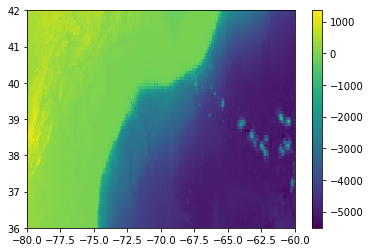

In [45]:
c = plt.pcolor(glorys.longitude, glorys.latitude, glorys_topo)
plt.colorbar(c)

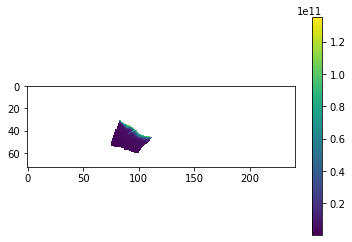

In [365]:
c = plt.imshow((area*(1000*1000))*((-1*glorys_topo) - d10[0,:,:]))
plt.colorbar(c)

In [366]:
np.shape(d10)

(324, 73, 241)

In [341]:
area


array([[68.78329817, 68.78329817, 68.78329817, ..., 68.78329817,
        68.78329817, 68.78329817],
       [68.71054262, 68.71054262, 68.71054262, ..., 68.71054262,
        68.71054262, 68.71054262],
       [68.63763874, 68.63763874, 68.63763874, ..., 68.63763874,
        68.63763874, 68.63763874],
       ...,
       [63.34801364, 63.34801364, 63.34801364, ..., 63.34801364,
        63.34801364, 63.34801364],
       [63.26546933, 63.26546933, 63.26546933, ..., 63.26546933,
        63.26546933, 63.26546933],
       [63.18279119, 63.18279119, 63.18279119, ..., 63.18279119,
        63.18279119, 63.18279119]])

In [367]:
volume = np.empty(324)
for i in range(324):
    volume[i] = np.nansum((area*(1000*1000))*((-1*glorys_topo) - d10[i,:,:]))

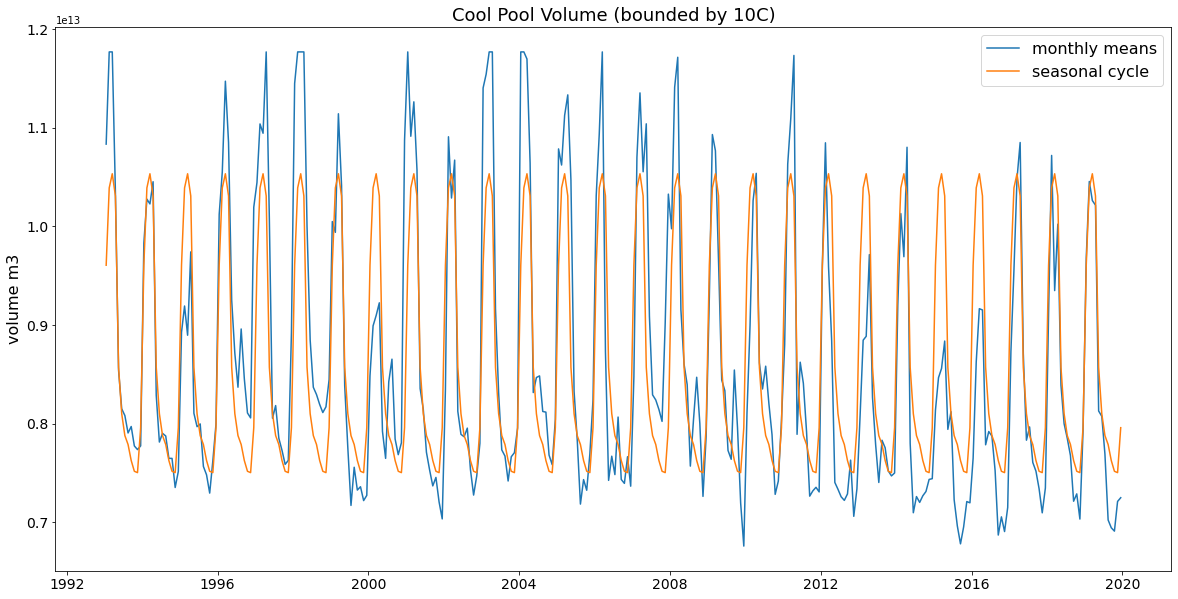

In [433]:
fig,ax = plt.subplots(figsize = [20,10])
ax.plot(glorys.time, volume, label = 'monthly means')
ax.plot(glorys.time,seasonal, label = 'seasonal cycle')
ax.tick_params(labelsize =14)
ax.set_ylabel('volume m3',fontsize = 16)
ax.set_title('Cool Pool Volume (bounded by 10C)', fontsize = 18)
ax.legend(fontsize = 16)

Text(0.5, 1.0, 'Cool Pool Volume (bounded by 10C)')

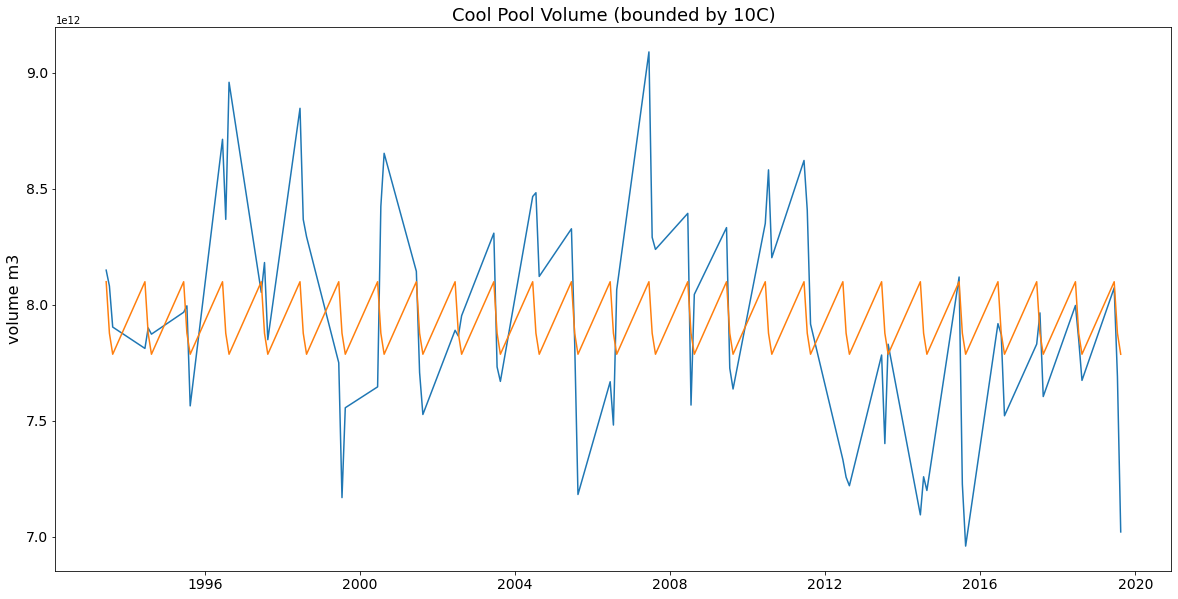

In [424]:
fig,ax = plt.subplots(figsize = [20,10])
ax.plot(glorys.time[JJA], volume[JJA])
ax.plot(glorys.time[JJA],seasonal[JJA])
ax.tick_params(labelsize =14)
ax.set_ylabel('volume m3',fontsize = 16)
ax.set_title('Cool Pool Volume (bounded by 10C)', fontsize = 18)

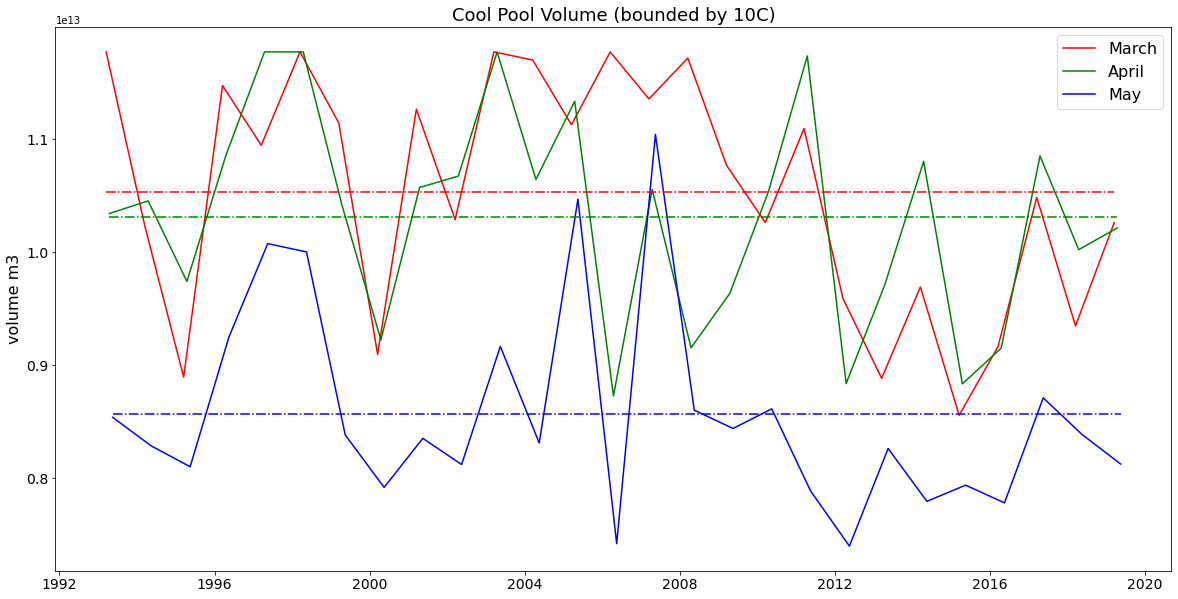

In [440]:
fig,ax = plt.subplots(figsize = [20,10])
ax.plot(glorys.time[Mar], volume[Mar],c = 'r', label = 'March')
ax.plot(glorys.time[Apr], volume[Apr], c = 'green', label = 'April')
ax.plot(glorys.time[May], volume[May], c = 'b', label = 'May')
ax.plot(glorys.time[Mar],seasonal[Mar], c= 'r', linestyle = '-.')
ax.plot(glorys.time[Apr],seasonal[Apr], c = 'green', linestyle = '-.')
ax.plot(glorys.time[May],seasonal[May], c='b', linestyle = '-.')
ax.tick_params(labelsize =14)
ax.set_ylabel('volume m3',fontsize = 16)
ax.set_title('Cool Pool Volume (bounded by 10C)', fontsize = 18)
ax.legend(fontsize = 16)

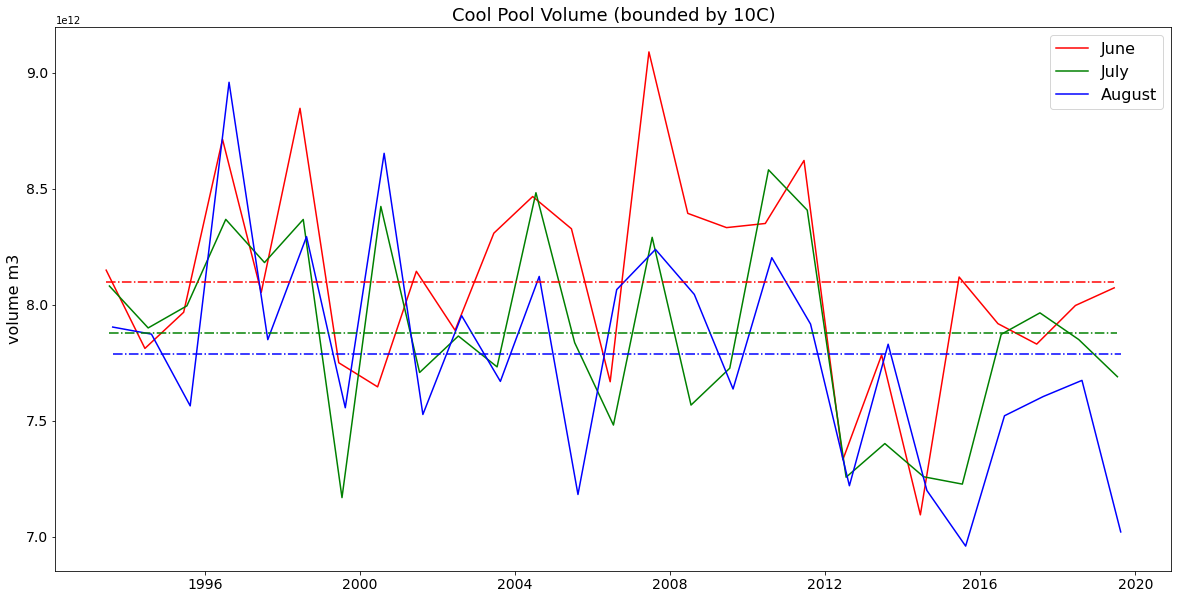

In [434]:
fig,ax = plt.subplots(figsize = [20,10])
ax.plot(glorys.time[Jun], volume[Jun],c = 'r', label = 'June')
ax.plot(glorys.time[Jul], volume[Jul], c = 'green', label = 'July')
ax.plot(glorys.time[Aug], volume[Aug], c = 'b', label = 'August')
ax.plot(glorys.time[Jun],seasonal[Jun], c= 'r', linestyle = '-.')
ax.plot(glorys.time[Jul],seasonal[Jul], c = 'green', linestyle = '-.')
ax.plot(glorys.time[Aug],seasonal[Aug], c='b', linestyle = '-.')
ax.tick_params(labelsize =14)
ax.set_ylabel('volume m3',fontsize = 16)
ax.set_title('Cool Pool Volume (bounded by 10C)', fontsize = 18)
ax.legend(fontsize = 16)

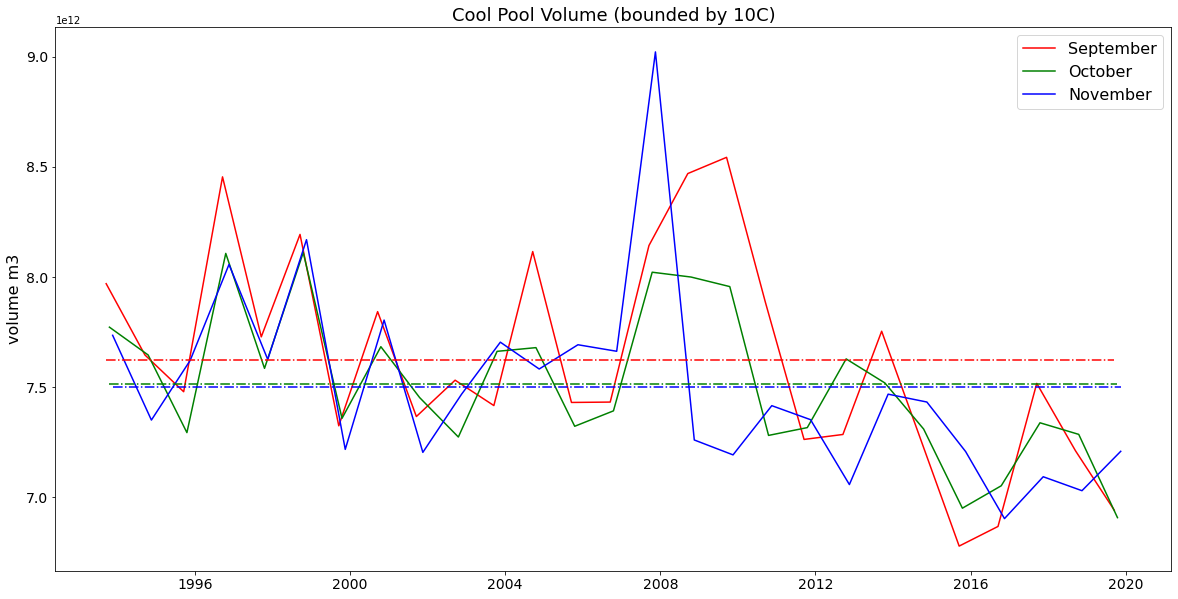

In [442]:
fig,ax = plt.subplots(figsize = [20,10])
ax.plot(glorys.time[Sep], volume[Sep],c = 'r', label = 'September')
ax.plot(glorys.time[Oct], volume[Oct], c = 'green', label = 'October')
ax.plot(glorys.time[Nov], volume[Nov], c = 'b', label = 'November')
ax.plot(glorys.time[Sep],seasonal[Sep], c= 'r', linestyle = '-.')
ax.plot(glorys.time[Oct],seasonal[Oct], c = 'green', linestyle = '-.')
ax.plot(glorys.time[Nov],seasonal[Nov], c='b', linestyle = '-.')
ax.tick_params(labelsize =14)
ax.set_ylabel('volume m3',fontsize = 16)
ax.set_title('Cool Pool Volume (bounded by 10C)', fontsize = 18)
ax.legend(fontsize = 16)

In [444]:
np.shape(glorys_nyb_theta)

(324, 41, 73, 241)

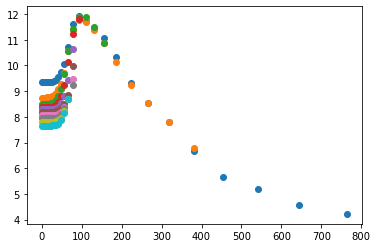

In [453]:
for i in range(45,55):
    j = 100
    plt.scatter(glorys.depth, glorys_nyb_theta[0,:,i,j])

In [466]:
glorys.time

<xarray.DataArray 'time' (time: 324)>
array(['1993-01-16T12:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-16T12:00:00.000000000', ..., '2019-10-16T12:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2019-12-16T12:00:00
Attributes:
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    _CoordinateAxisType:  Time
    valid_min:            377316.0
    valid_max:            481764.0

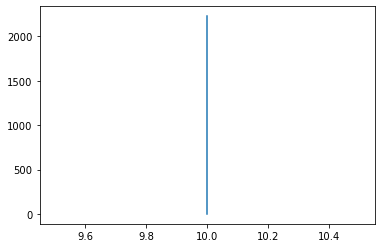

In [476]:
plt.plot([10,10],[glorys.depth[0],glorys.depth[-1]])

<ipython-input-483-f50cb95be8b8>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-483-f50cb95be8b8>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-483-f50cb95be8b8>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-483-f50cb95be8b8>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-483-f50cb95be8b8>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-483-f50cb95be8b8>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
<ipy

Text(0.5, 1.0, 'Aug 10s')

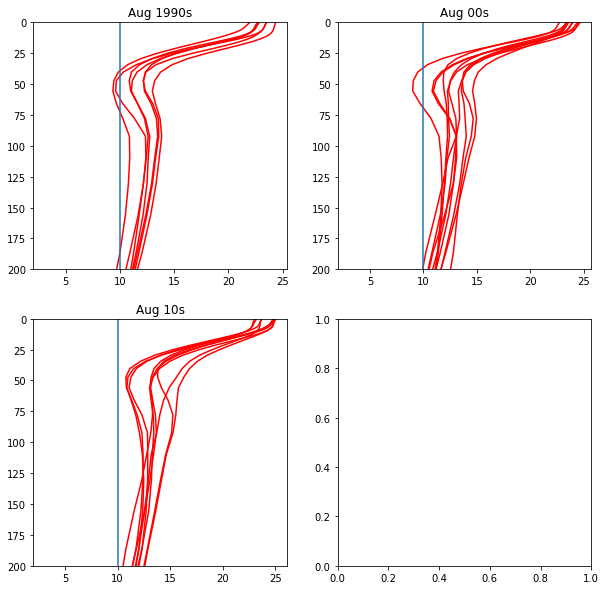

In [483]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])
for i in range(7):
    ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
    ax[0,0].set_ylim([200,0])
for i in range(8,18):
    ax[0,1].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
    ax[0,1].set_ylim([200,0])
for i in range(18,27):
    ax[1,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[i],:,:,:],2),1),glorys.depth,c='r')
    ax[1,0].set_ylim([200,0])
ax[0,0].plot([10,10],[0,200])
ax[0,0].set_ylim([200,0])
ax[0,0].set_title('Aug 1990s')
ax[1,0].plot([10,10],[0,200])
ax[1,0].set_ylim([200,0])
ax[0,1].set_title('Aug 00s')
ax[0,1].plot([10,10],[0,200])
ax[0,1].set_ylim([200,0])
ax[1,0].set_title('Aug 10s')

<ipython-input-506-dfad1faa450f>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-506-dfad1faa450f>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-506-dfad1faa450f>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-506-dfad1faa450f>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-506-dfad1faa450f>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
<ipython-input-506-dfad1faa450f>:3: RuntimeWarning: Mean of empty slice
  ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
<ipy

Text(0.5, 1.0, 'Mar 10s')

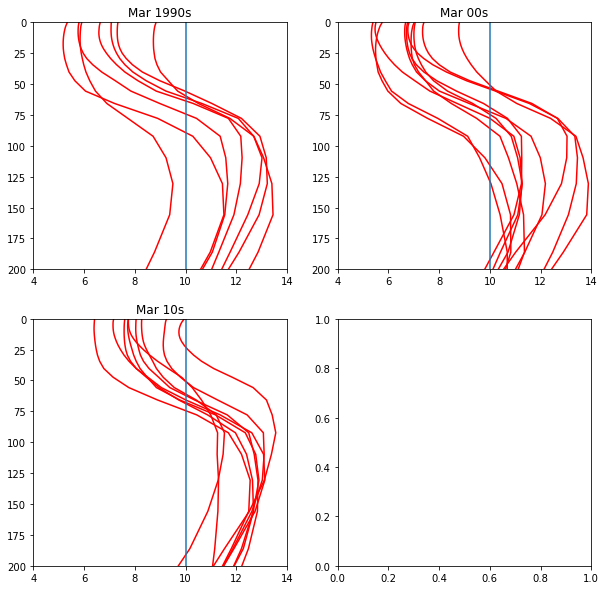

In [506]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])
for i in range(7):
    ax[0,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
    ax[0,0].set_ylim([200,0])
    ax[0,0].set_xlim([4,14])
for i in range(8,18):
    ax[0,1].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
    ax[0,1].set_ylim([200,0])
    ax[0,1].set_xlim([4,14])
for i in range(18,27):
    ax[1,0].plot(np.nanmean(np.nanmean(glorys_nyb_theta[Mar[i],:,:,:],2),1),glorys.depth,c='r')
    ax[1,0].set_ylim([200,0])
    ax[1,0].set_xlim([4,14])
ax[0,0].plot([10,10],[0,200])
ax[0,0].set_ylim([200,0])
ax[0,0].set_title('Mar 1990s')
ax[1,0].plot([10,10],[0,200])
ax[1,0].set_ylim([200,0])
ax[0,1].set_title('Mar 00s')
ax[0,1].plot([10,10],[0,200])
ax[0,1].set_ylim([200,0])
ax[1,0].set_title('Mar 10s')

<ipython-input-507-b307e9628b7e>:7: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[k],:,:,:],2),1),glorys.depth,c='k')
<ipython-input-507-b307e9628b7e>:7: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[k],:,:,:],2),1),glorys.depth,c='k')
<ipython-input-507-b307e9628b7e>:7: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[k],:,:,:],2),1),glorys.depth,c='k')
<ipython-input-507-b307e9628b7e>:7: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[k],:,:,:],2),1),glorys.depth,c='k')
<ipython-input-507-b307e9628b7e>:7: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[k],:,:,:],2),1),glorys.depth,c='k')
<ipython-input-507-b307e9628b7e>:7: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[k],:,:,:],2),1),glorys.depth,c='k')
<ipython-input-507-b307e9628b7e>:7

(100.0, 0.0)

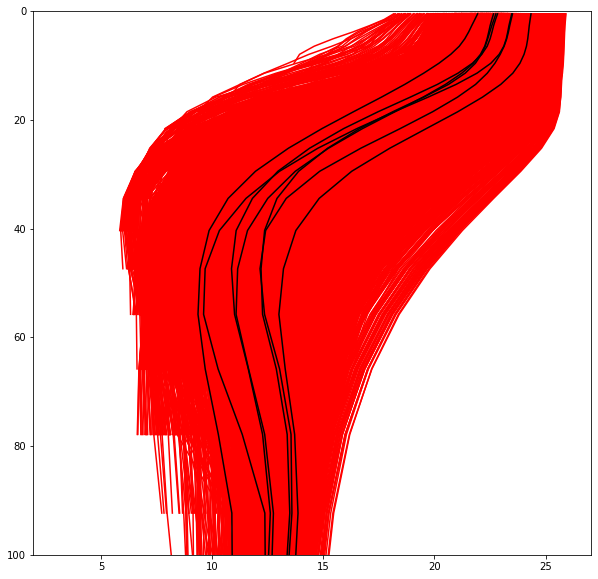

In [507]:
fig,ax = plt.subplots(figsize = [10,10])
for k in range(7):
    for i in range(73):
        for j in range(241):
            ax.plot(glorys_nyb_theta[Aug[k],:,i,j],glorys.depth,c='r')
for k in range(7):
    ax.plot(np.nanmean(np.nanmean(glorys_nyb_theta[Aug[k],:,:,:],2),1),glorys.depth,c='k')
ax.set_ylim([100,0])

In [511]:
np.shape(d10)

(324, 73, 241)

<ipython-input-542-87139fa7f7e2>:9: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z, cmap="autumn_r",vmin=np.nanmin(Z), vmax=np.nanmax(Z), lw=0.5, rstride=1, cstride=1, alpha=0.5)


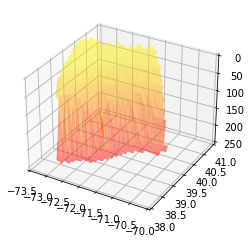

In [542]:
 
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(glorys.longitude, glorys.latitude)
Z = d10[7,:,:]
ax.plot_surface(X, Y, Z, cmap="autumn_r",vmin=np.nanmin(Z), vmax=np.nanmax(Z), lw=0.5, rstride=1, cstride=1, alpha=0.5)
#ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
#ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.set_ylim([38, 41])
ax.set_xlim([-73.5,-70])
ax.set_zlim([250,0])
plt.show()

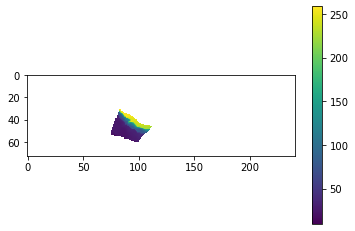

In [527]:
c = plt.imshow(d10[7,:,:])
plt.colorbar(c)

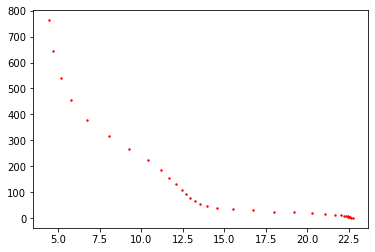

In [495]:
plt.scatter(glorys_nyb_theta[Aug[0],:,45,100],glorys.depth,c='r',s = 2)

In [381]:
vol = xr.Dataset(data_vars = {'volume':('time',volume)}, coords = {'time': ('time',glorys.time)})

In [416]:
seas = vol.volume.groupby('time.month').mean('time')
seasonal = seas
for i in range(26):
    seasonal = np.append(seasonal,seas)


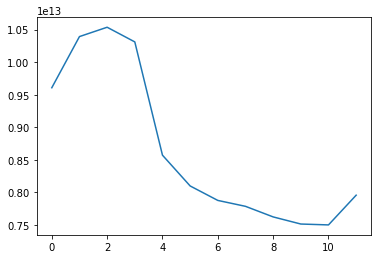

In [419]:
JJA = 

In [415]:
glorys.time

<xarray.DataArray 'time' (time: 324)>
array(['1993-01-16T12:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-16T12:00:00.000000000', ..., '2019-10-16T12:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2019-12-16T12:00:00
Attributes:
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    _CoordinateAxisType:  Time
    valid_min:            377316.0
    valid_max:            481764.0

Text(0.5, 1.0, 'Cool Pool Volume (bounded by 10C)')

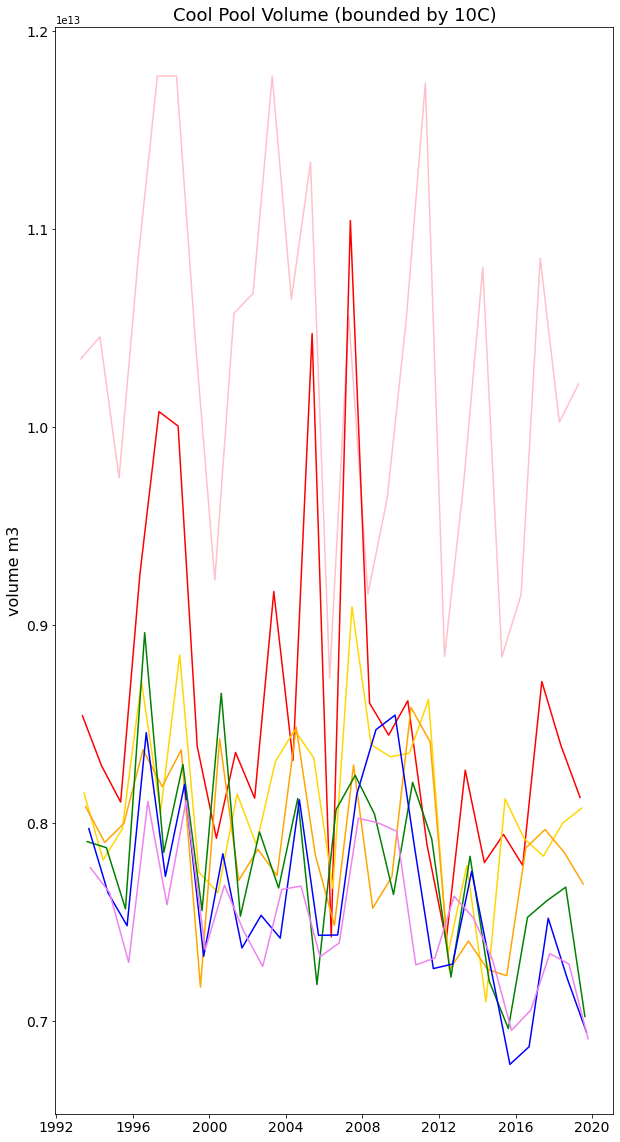

In [441]:
Mar = np.arange(2,324,12)
Apr = np.arange(3,324,12)
May = np.arange(4,324,12)
Jun = np.arange(5,324,12)
Jul = np.arange(6,324,12)
Aug = np.arange(7,324,12)
Sep = np.arange(8,324,12)
Oct = np.arange(9,324,12)
Nov = np.arange(10,324,12)
fig,ax = plt.subplots(figsize = [10,20])
ax.plot(glorys.time[Apr], volume[Apr],color = 'pink')
ax.plot(glorys.time[May], volume[May], c= 'r')
ax.plot(glorys.time[Jun], volume[Jun], c = 'gold')
ax.plot(glorys.time[Jul], volume[Jul], c= 'orange')
ax.plot(glorys.time[Aug], volume[Aug], c = 'green')
ax.plot(glorys.time[Sep], volume[Sep], c = 'blue')
ax.plot(glorys.time[Oct], volume[Oct], c = 'violet')
ax.tick_params(labelsize =14)
ax.set_ylabel('volume m3',fontsize = 16)
ax.set_title('Cool Pool Volume (bounded by 10C)', fontsize = 18)

In [423]:
JJA = np.append(Jun,[Jul,Aug])
JJA = np.sort(JJA)

In [177]:
max(volume)
volume_cp = volume
volume_cp[np.where(volume_cp==max(volume_cp))] = np.nan

In [192]:
volume_april = volume[np.where(pn.to_datetime(glorys.time.values).month)==4]

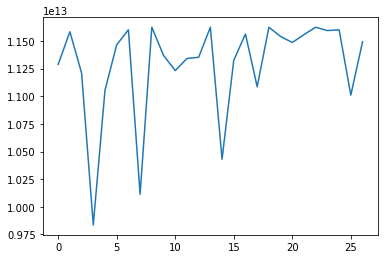

In [220]:
#plt.plot(volume[pn.to_datetime(glorys.time.values).month==4])
plt.plot(volume[pn.to_datetime(glorys.time.values).month==12])

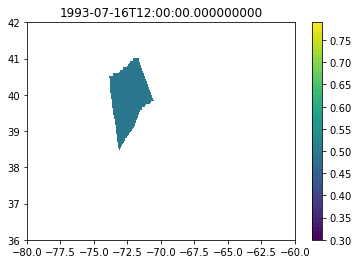

In [245]:
i=6
c = plt.contourf(glorys.longitude,glorys.latitude,d10[i,:,:],levels = np.arange(0.3,0.8,.01))
plt.title(glorys.time[i].values)
plt.colorbar(c)

In [251]:


import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


d10[i,:,:] 

array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,         

In [239]:
np.nanmin(d10[i,:,:])

0.49402499198913574

In [188]:
pn.to_datetime(glorys.time.values).month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
             3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
           dtype='int64', length=324)

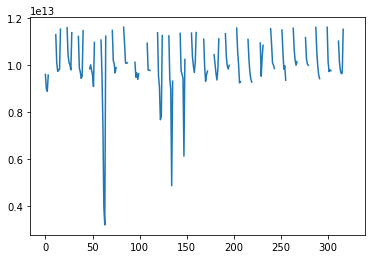

In [179]:
plt.plot(volume_cp)

In [153]:
area*(1000*1000)

array([[68783298.16881359, 68783298.16881359, 68783298.16881359, ...,
        68783298.16881359, 68783298.16881359, 68783298.16881359],
       [68710542.62301783, 68710542.62301783, 68710542.62301783, ...,
        68710542.62301783, 68710542.62301783, 68710542.62301783],
       [68637638.74207413, 68637638.74207413, 68637638.74207413, ...,
        68637638.74207413, 68637638.74207413, 68637638.74207413],
       ...,
       [63348013.64162101, 63348013.64162101, 63348013.64162101, ...,
        63348013.64162101, 63348013.64162101, 63348013.64162101],
       [63265469.33402574, 63265469.33402574, 63265469.33402574, ...,
        63265469.33402574, 63265469.33402574, 63265469.33402574],
       [63182791.18896262, 63182791.18896262, 63182791.18896262, ...,
        63182791.18896262, 63182791.18896262, 63182791.18896262]])

In [105]:
topo.y[np.arange(7560,7921,5)]

<xarray.DataArray 'y' (y: 73)>
array([36.      , 36.083333, 36.166667, 36.25    , 36.333333, 36.416667,
       36.5     , 36.583333, 36.666667, 36.75    , 36.833333, 36.916667,
       37.      , 37.083333, 37.166667, 37.25    , 37.333333, 37.416667,
       37.5     , 37.583333, 37.666667, 37.75    , 37.833333, 37.916667,
       38.      , 38.083333, 38.166667, 38.25    , 38.333333, 38.416667,
       38.5     , 38.583333, 38.666667, 38.75    , 38.833333, 38.916667,
       39.      , 39.083333, 39.166667, 39.25    , 39.333333, 39.416667,
       39.5     , 39.583333, 39.666667, 39.75    , 39.833333, 39.916667,
       40.      , 40.083333, 40.166667, 40.25    , 40.333333, 40.416667,
       40.5     , 40.583333, 40.666667, 40.75    , 40.833333, 40.916667,
       41.      , 41.083333, 41.166667, 41.25    , 41.333333, 41.416667,
       41.5     , 41.583333, 41.666667, 41.75    , 41.833333, 41.916667,
       42.      ])
Coordinates:
  * y        (y) float64 36.0 36.08 36.17 36.25 36.33 ... 41.75 41.83 41.92 42.0
Attributes:
    long_name:     Latitude
    actual_range:  [-90.  90.]
    units:         degrees_north

In [545]:
topo

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Bed_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

In [256]:
np.shape(glorys_nyb_bot_t)

(324, 73, 241)

In [274]:
pn.to_datetime(glorys.time[0].values).dayofyear

16

In [310]:
t2 = np.empty(5700132)
t2[:] = np.nan
a=0
for i in range(324):
    for j in range(73):
        for k in range(241):
            te= glorys_nyb_bot_t[i,j,k]
            if te>0:
                t2[a] = str(glorys.time[i].values)
                a=a+1

ValueError: could not convert string to float: '1993-01-16T12:00:00.000000000'

In [294]:
temp2 = np.empty(5700132)
temp2[:] = np.nan
lat2 = np.empty(5700132)
lat2[:] = np.nan
lon2 = np.empty(5700132)
lon2[:] = np.nan
t2 = np.empty(5700132)
t2[:] = np.nan
year2 = np.empty(5700132)
year2[:] = np.nan
month2 = np.empty(5700132)
month2[:] = np.nan
day2 = np.empty(5700132)
day2[:] = np.nan
yday2 = np.empty(5700132)
yday2[:] = np.nan
a=0
for i in range(324):
    for j in range(73):
        for k in range(241):
            temp2[a] = glorys_nyb_bot_t[i,j,k]
            if temp2[a]>0:
                lat2[a] = glorys.latitude[j]
                lon2[a] = glorys.longitude[k]
                t2[a] = str(glorys.time[i].values)
                year2[a] = pn.to_datetime(t[a]).year
                month2[a] = pn.to_datetime(t[a]).month
                day2[a] = pn.to_datetime(t[a]).day
                yday2[a] = pn.to_datetime(t[a]).dayofyear
                a=a+1
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

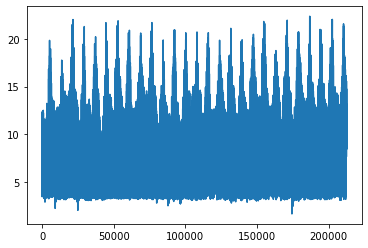

In [295]:
plt.plot(temp2)

In [303]:
bottom_temp = pn.DataFrame({'lon': lon2, 'lat':lat2, 't':t2, 'temp':temp2, 'year': year2, 'month': month2, 'day':day2, 'yday': yday2})

In [304]:
bottom_temp = bottom_temp[bottom_temp.temp>0]

In [305]:
bottom_temp

,lon,lat,t,temp,year,month,day,yday
0,-73.083336,38.500000,7.271856e+17,3.711386,1993.0,1.0,16.0,16.0
1,-73.166664,38.583332,7.271856e+17,5.970244,1993.0,1.0,16.0,16.0
2,-73.083336,38.583332,7.271856e+17,3.902554,1993.0,1.0,16.0,16.0
3,-73.000000,38.583332,7.271856e+17,3.744347,1993.0,1.0,16.0,16.0
4,-73.166664,38.666668,7.271856e+17,11.426954,1993.0,1.0,16.0,16.0
...,...,...,...,...,...,...,...,...
212539,-72.000000,41.000000,1.576498e+18,8.601916,1994.0,1.0,16.0,16.0
212540,-71.916664,41.000000,1.576498e+18,8.993042,1994.0,1.0,16.0,16.0
212541,-71.833336,41.000000,1.576498e+18,9.822168,1994.0,1.0,16.0,16.0
212542,-71.750000,41.000000,1.576498e+18,12.016572,1994.0,1.0,16.0,16.0


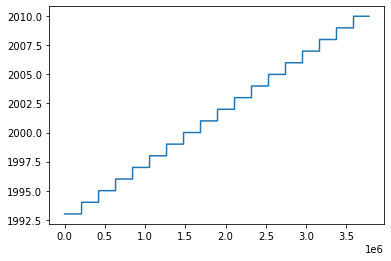